In [93]:
# from https://github.com/HANTLUK/PauliDecomposition
import numpy as np
from TensorizedPauliDecomposition import PauliDecomposition
from qiskit.quantum_info import SparsePauliOp
import matplotlib.pyplot as plt
import time
import csv

In [94]:
def sparsePauliOeratorLCU(matrix):
	testResult2 = SparsePauliOp.from_operator(matrix)
	coeffs2 = testResult2.coeffs
	list2 = testResult2.paulis
	return [list2,coeffs2]

def tensorizedPauliDecompositionLCU(matrix):
	list1, coeffs1 = PauliDecomposition(matrix)
	return [list1,coeffs1]

def randomMatrix(dim):
	return np.add(np.random.rand(dim,dim),1.j*np.random.rand(dim,dim))

def comparison(method1, method2, matrix):
	start = time.time()
	list1,coeffs1 = method1(matrix)
	end = time.time()
	method1Time = end-start
	print (method1.__name__,"time:",method1Time, "coefLen", len(coeffs1))
	start = time.time()
	list2,coeffs2 = method2(matrix)
	end = time.time()
	method2Time = end-start
	print (method2.__name__,"time:",method2Time, "coefLen", len(coeffs2))
	equal = True
	for x,y in zip(list1,list2):
		if str(x) != str(y):
			equal = False
	eps = 10**(-5)
	for x,y in zip(coeffs1,coeffs2):
		if abs(complex(x) - complex(y)) > eps:
			equal = False
	return equal, method1Time, method2Time

In [95]:
tpdTimes, sparsePauliOpTimes = [],[]
qubits = 8

for i in range (1,qubits+1):
    print("qubits: ",i)
    testMatrix = randomMatrix(2**i)
    equal, method1, method2 = comparison(tensorizedPauliDecompositionLCU,sparsePauliOeratorLCU,testMatrix)
    print(equal)
    tpdTimes.append(method1)
    sparsePauliOpTimes.append(method2)

qubits:  1
tensorizedPauliDecompositionLCU time: 6.985664367675781e-05 coefLen 4
sparsePauliOeratorLCU time: 0.0013451576232910156 coefLen 4
True
qubits:  2
tensorizedPauliDecompositionLCU time: 0.00016307830810546875 coefLen 16
sparsePauliOeratorLCU time: 0.001584768295288086 coefLen 16
True
qubits:  3
tensorizedPauliDecompositionLCU time: 0.0006208419799804688 coefLen 64
sparsePauliOeratorLCU time: 0.0036101341247558594 coefLen 64
True
qubits:  4
tensorizedPauliDecompositionLCU time: 0.0021820068359375 coefLen 256
sparsePauliOeratorLCU time: 0.01197504997253418 coefLen 256
True
qubits:  5
tensorizedPauliDecompositionLCU time: 0.007556915283203125 coefLen 1024
sparsePauliOeratorLCU time: 0.04664015769958496 coefLen 1024
True
qubits:  6
tensorizedPauliDecompositionLCU time: 0.02413797378540039 coefLen 4096
sparsePauliOeratorLCU time: 1.381939172744751 coefLen 4096
True
qubits:  7
tensorizedPauliDecompositionLCU time: 0.12784099578857422 coefLen 16384
sparsePauliOeratorLCU time: 7.15986

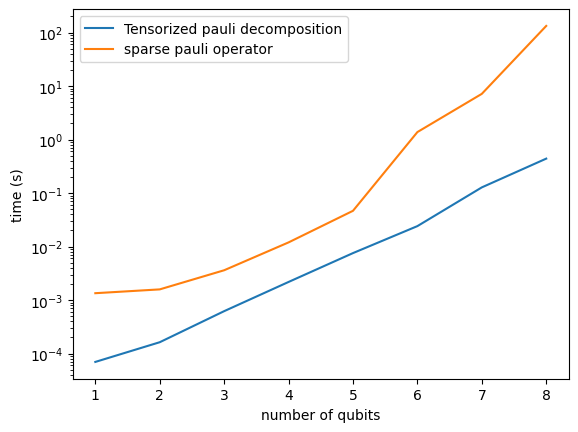

In [96]:
plt.plot(tpdTimes, label = "Tensorized pauli decomposition")
plt.plot(sparsePauliOpTimes, label = "sparse pauli operator")
plt.xlabel("number of qubits")
plt.ylabel("time (s)")
plt.yscale('log')
plt.xticks(np.arange(qubits),np.arange(1,qubits+1))
ax = plt.gca()
plt.legend()

In [97]:
with open('resultsLCU.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Number of qubits","Tensorized Pauli Decomposition", "Sparse Pauli Operator"])
    for i in range(qubits):
        writer.writerow([i+1,tpdTimes[i], sparsePauliOpTimes[i]])

In [98]:
import LSSVM
from VQLSSVM import VQLSSVM
from sklearn import datasets
from sklearn.model_selection import train_test_split
classToFilterOut: int = 2
shots: int = 10000
gamma: float = 0.01 # regularization parameter
vqlssvmVectors: VQLSSVM = VQLSSVM(gamma, shots)
def prepareDataset(normalizeValues: bool = False, dataset: str = "iris", subsetSize= 7) -> (np.ndarray, np.ndarray, np.array, np.array):
    if dataset == "iris":
        X,y = datasets.load_iris(return_X_y=True)
        X = X[y!=classToFilterOut]
        y = y[y!=classToFilterOut]
    elif dataset == "breastCancer":
        X,y = datasets.load_breast_cancer(return_X_y=True)
    elif dataset == "dummyData":
        X, y = datasets.make_classification(
            n_samples=50, n_features=2, n_informative=2, n_redundant=0, random_state=45
        )
    elif dataset == "digits":
        X, y = datasets.load_digits(n_class=2, return_X_y=True)
    elif dataset == "wine":
        X, y = datasets.load_wine(return_X_y=True) # 3 classes; filter out some class
    else: 
        raise ValueError("Dataset not yet implemented")
    y: np.array = np.where(y == 0, -1, 1) # might cause some problems in a future

    if normalizeValues: # normalize values returns nan with digits dataset
        max = np.max(X, axis=0)
        min = np.min(X, axis=0)
        X = (2*X - min - max) / (max - min)
    return train_test_split(X, y, test_size=(X.shape[0]-subsetSize)/(X.shape[0]), random_state=43)

In [99]:
tpdTimesOne = []
qubits = 8

for i in range (1,qubits+1):
    xTrain, xTest, yTrain, yTest = prepareDataset(normalizeValues=True, dataset="breastCancer", subsetSize=2**i-1)
    input = LSSVM.lssvmMatrix(xTrain, gamma, "linearKernel")
    print("qubits: ",i)
    testMatrix = input
    start = time.time()
    list1,coeffs1 = tensorizedPauliDecompositionLCU(testMatrix)
    end = time.time()
    tpdTimesOne.append(end-start)
    print(tpdTimesOne[-1])
    print(len(coeffs1))

qubits:  1
0.0004000663757324219
3
qubits:  2
0.00011277198791503906
10
qubits:  3
0.00037407875061035156
36
qubits:  4
0.001428842544555664
136
qubits:  5
0.0056362152099609375
528
qubits:  6
0.021891117095947266
2080
qubits:  7
0.08683395385742188
8256
qubits:  8
0.3511059284210205
32896


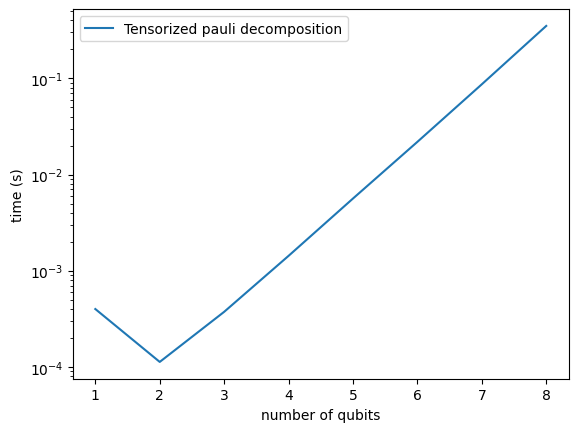

In [100]:
plt.plot(tpdTimesOne, label = "Tensorized pauli decomposition")
plt.xlabel("number of qubits")
plt.ylabel("time (s)")
plt.yscale('log')
plt.xticks(np.arange(qubits),np.arange(1,qubits+1))
ax = plt.gca()
plt.legend()